# Try [`scuff-em`](http://homerreid.github.io/scuff-em-documentation/) in your browser!
This uses the services of [mybinder.org](http://mybinder.org) to run a Docker container with `scuff-em` precompiled in the browser, with the interface provided by [Jupyter](http://jupyter.org) notebooks. The notebook is written in python 3 using the [IPython kernel](http://ipython.readthedocs.org/en/latest/), which provides convenient "magic" functions to call shell commands etc, but also allows for nice plotting in the notebook.

## some minimal setup code for plotting

In [1]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']
style.use(['seaborn-deep','seaborn-notebook'])

Populating the interactive namespace from numpy and matplotlib


# Try some scuff example
We have included all the examples of `scuff-em` here. Check what is available:

In [5]:
%ls

CorrugatedDisc/       PerforatedThinFilm/  SiliconBeams/    index.ipynb
CubeTorus/            PlateWithHole/       SolidSphere/     scuff*
DiffractionPatterns/  PlatonicSolids/      SphericalShell/
Dockerfile            README.md            ThinFilm/
GetTMatrix/           SiO2Spheres/         WireAntenna/


# Mie scattering example
We now follow the [Mie Scattering](http://homerreid.github.io/scuff-em-documentation/examples/MieScattering/MieScattering/) example from the scuff-em documentation.

In [7]:
%cd SolidSphere
%ls

/home/main/notebooks/SolidSphere
Args                 OmegaValues.dat    SiCSphere.scuffgeo  Sphere.msh
GoldSphere.scuffgeo  SiCSphere.moments  Sphere.cache        scuff-scatter.log
Mie.math             SiCSphere.pft      Sphere.geo          tmp.gmsh


In [8]:
%%bash
gmsh -2 -clscale 1.0 Sphere.geo

Info    : Running 'gmsh -2 -clscale 1.0 Sphere.geo' [Gmsh 2.8.5, 1 node, max. 1 thread]
Info    : Started on Fri Feb 26 13:58:52 2016
Info    : Reading 'Sphere.geo'...
Info    : Done reading 'Sphere.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Meshing curve 2 (Circle)
Info    : Meshing curve 3 (Circle)
Info    : Meshing curve 4 (Circle)
Info    : Meshing curve 5 (Circle)
Info    : Meshing curve 6 (Circle)
Info    : Meshing curve 7 (Circle)
Info    : Meshing curve 8 (Circle)
Info    : Meshing curve 9 (Circle)
Info    : Meshing curve 10 (Circle)
Info    : Meshing curve 11 (Circle)
Info    : Meshing curve 12 (Circle)
Info    : Done meshing 1D (0 s)
Info    : Meshing 2D...
Info    : Meshing surface 14 (Ruled surface, MeshAdapt)
Info    : Meshing surface 16 (Ruled surface, MeshAdapt)
Info    : Meshing surface 18 (Ruled surface, MeshAdapt)
Info    : Meshing surface 20 (Ruled surface, MeshAdapt)
Info    : Meshing surface 22 (Ruled surface, MeshAdapt)
Info    : Mes

In [9]:
%%bash
cat SiCSphere.scuffgeo

MATERIAL SiliconCarbide

   EpsInf = 6.7;
   a0     = -3.32377e28;
   a1     = +8.93329e11; 
   b0     = -2.21677e28;
   b1     = 8.93329e11;
   Eps(w) = EpsInf * (a0 + i*a1*w + w*w) / ( b0 + i*b1*w + w*w);

ENDMATERIAL

OBJECT TheSphere
	MESHFILE Sphere.msh
	MATERIAL CONST_EPS_10+10i
ENDOBJECT




In [10]:
%%bash
head -2 OmegaValues.dat
echo "..."
tail -2 OmegaValues.dat

0.010
0.013
...
3.900
5.000


In [12]:
%%bash
cat Args

geometry SiCSphere.scuffgeo
OmegaFile OmegaValues.dat
PFTFile   SiCSphere.pft
MomentFile SiCSphere.moments
Cache Sphere.cache
pwDirection 0 0 1
pwPolarization 1 0 0


In [13]:
%%bash
scuff-scatter < Args

Thank you for your support.


In [16]:
%ls

Args                 SiC.mie             Sphere.cache    scuff-scatter.log
GoldSphere.scuffgeo  SiCSphere.moments   Sphere.geo      tmp.gmsh
Mie.math             SiCSphere.pft       Sphere.msh
OmegaValues.dat      SiCSphere.scuffgeo  Untitled.ipynb


# Plot the results

In [17]:
# columns in SiC.mie:
#   0: size parameter (ka = 2*pi*a / lambda ; a = sphere radius)
#   1: Re Eps(w)
#   2: Im Eps(w)
#   3: Sigma_Absorption
#   4: Sigma_Scattering
#   5: maximum l-value of spherical multipoles retained to achieve
#      two-digit accuracy in computing the cross-sections     
mie_data = loadtxt('SiC.mie',unpack=True)

In [18]:
!head -13 SiCSphere.pft
# column 2 (number 1 in python 0-based indexing) has text, ignore that one
usecols = [0] + list(range(2,10))
scuff_data = loadtxt('SiCSphere.pft',unpack=True,usecols=usecols)

# scuff-scatter run on notebook-server (02/26/16::13:51:46)
# data file columns: 
# 1 omega           (rad/sec) 
# 2 surface label 
# 3 absorbed power  (watts)
# 4 scattered power (watts)
# 5 x-force         (nanonewtons)
# 6 y-force         (nanonewtons)
# 7 z-force         (nanonewtons)
# 8 x-torque        (nanonewtons * microns)
# 9 y-torque        (nanonewtons * microns)
#10 z-torque        (nanonewtons * microns)
0.01 TheSphere 1.982201e-05 7.696952e-11 -1.250770e-05 -6.713735e-06 6.534411e-05 -4.461608e-06 1.697143e-05 3.266937e-05 


In [24]:
# prefactor to convert from Mie cross section to scattered power, Z0 = 376. in scuff units
cS=1/(2*376.73031346177)

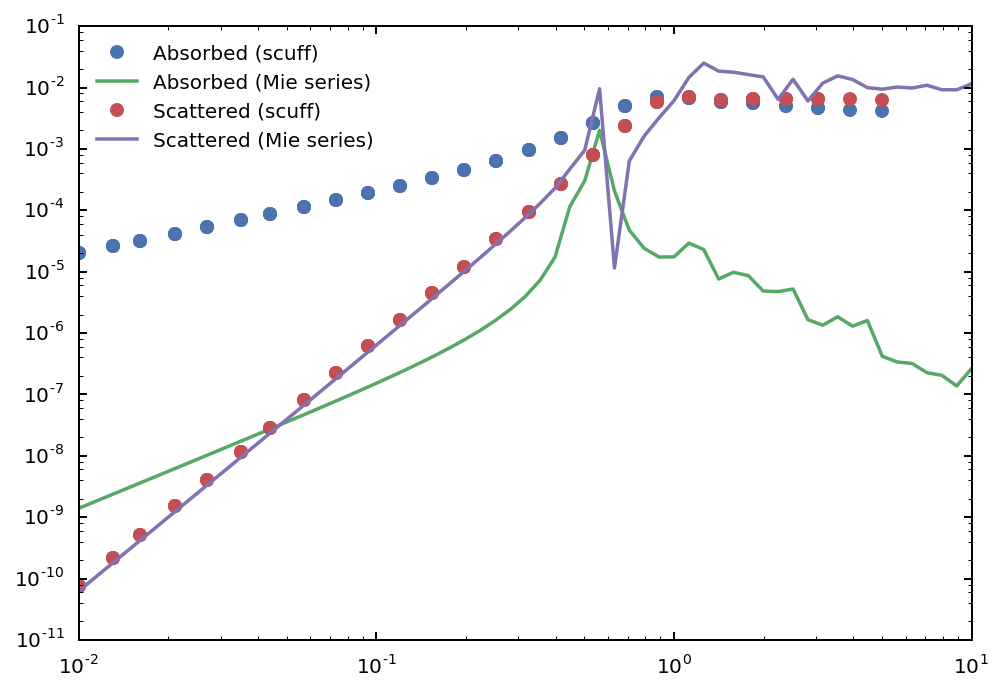

In [37]:
plot(   scuff_kR, scuff_data[1],'o',label='Absorbed (scuff)')
plot(mie_data[0],cS*mie_data[3],'-',label='Absorbed (Mie series)')
plot(   scuff_kR, scuff_data[2],'o',label='Scattered (scuff)')
plot(mie_data[0],cS*mie_data[4],'-',label='Scattered (Mie series)')
xscale('log')
yscale('log')
xlim(1e-2,1e1)
ylim(1e-11,0.1)
legend(loc='best',frameon=False,numpoints=1);